In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard

2024-03-31 15:04:06.257374: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Khai báo các thông số
img_width, img_height = 224, 224
batch_size = 16
epochs = 10
num_classes = 3

In [4]:
# Đường dẫn đến thư mục chứa dữ liệu
data_dir = '../rmbg_dataset/0.5'

# Danh sách các lớp (classes) là các thư mục con trong thư mục chứa dữ liệu
classes = os.listdir(data_dir)
print(classes)

['torso', 'leg', 'arm']


In [5]:
# Tạo empty lists để lưu trữ đường dẫn hình ảnh và nhãn tương ứng
image_paths = []
labels = []

# Lặp qua mỗi lớp
for class_label in classes:
  class_dir = os.path.join(data_dir, class_label)
  # Lặp qua mỗi hình ảnh trong mỗi lớp
  for image_name in os.listdir(class_dir):
    image_path = os.path.join(class_dir, image_name)
    image_paths.append(image_path)
    labels.append(class_label)

# Chia dữ liệu thành tập huấn luyện và tập validation
train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Tạo DataFrame cho tập huấn luyện
train_dataframe = pd.DataFrame({'image_path': train_image_paths, 'label': train_labels})
# Tạo DataFrame cho tập validation
val_dataframe = pd.DataFrame({'image_path': val_image_paths, 'label': val_labels})

In [6]:
# Tạo ImageDataGenerator cho tập huấn luyện
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Chuẩn hóa lại giá trị pixel về khoảng [0,1]
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Tạo ImageDataGenerator cho tập validation, chỉ cần rescale lại giá trị pixel
val_datagen = ImageDataGenerator(rescale=1./255)

# Tạo generator cho tập huấn luyện
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_dataframe,  # DataFrame chứa đường dẫn hình ảnh và nhãn cho tập huấn luyện
    x_col="image_path",
    y_col="label",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Tạo generator cho tập validation
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_dataframe,  # DataFrame chứa đường dẫn hình ảnh và nhãn cho tập validation
    x_col="image_path",
    y_col="label",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 84 validated image filenames belonging to 3 classes.
Found 21 validated image filenames belonging to 3 classes.


In [7]:
# Load pre-trained ResNet50 model without top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 4d473c1dd8becc155b73f8504c6f6626 so we will re-download the data.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 56s 1us/step


In [8]:
# Add custom layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [9]:
# Freeze convolutional base
base_model.trainable = False

In [10]:
# Compile model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [11]:
# Định nghĩa callback để ghi log TensorBoard
log_dir = "/content/drive/MyDrive/Colab Notebooks/Experimental/ResNet50/logs/fit"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [12]:
# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size)

Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.4406 - loss: 14.1356 - val_accuracy: 0.3125 - val_loss: 8.1576
Epoch 2/10
1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.2500 - loss: 8.4221

2024-03-31 15:05:29.795825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.2500 - loss: 5.0532 - val_accuracy: 0.0000e+00 - val_loss: 8.0480
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4434 - loss: 3.2018 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/10


2024-03-31 15:05:35.853331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6250 - loss: 4.7048

2024-03-31 15:05:37.094469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - accuracy: 0.6250 - loss: 2.8229 - val_accuracy: 0.3125 - val_loss: 7.8168
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6754 - loss: 4.1234 - val_accuracy: 0.6000 - val_loss: 0.4552
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5625 - loss: 2.6297 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10


2024-03-31 15:05:47.916905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 15:05:47.932000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6381 - loss: 2.0236 - val_accuracy: 0.5000 - val_loss: 1.9944
Epoch 8/10
1/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4375 - loss: 2.0776

2024-03-31 15:05:58.210929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.4375 - loss: 1.2466 - val_accuracy: 0.6000 - val_loss: 1.1419
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6096 - loss: 1.3307 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/10


2024-03-31 15:06:05.907893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7500 - loss: 0.5292

2024-03-31 15:06:07.279590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - accuracy: 0.7500 - loss: 0.3175 - val_accuracy: 0.6875 - val_loss: 0.8002


In [13]:
# Evaluate the model
test_loss, test_acc = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print('Test accuracy:', test_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6875 - loss: 0.7345
Test accuracy: 0.6875


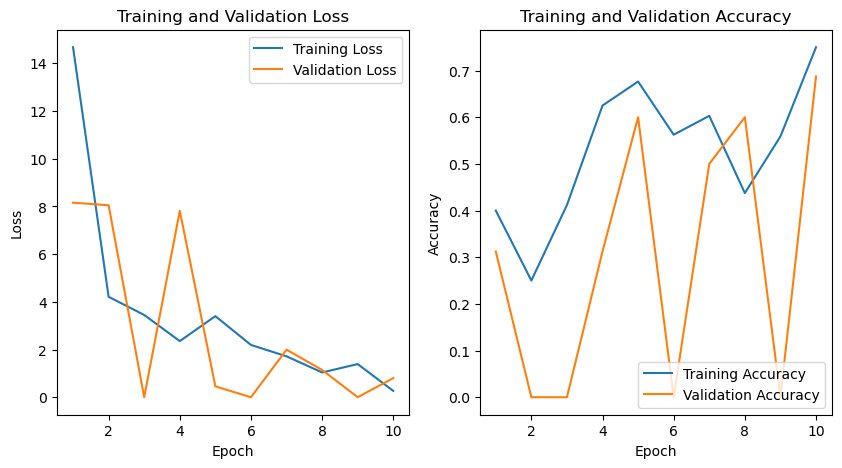

In [14]:
# Visualize loss and accuracy

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(1, epochs+1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()